<a href="https://colab.research.google.com/github/iris-kurapaty/Batch-Normalization/blob/main/Batch_Normalization_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
pwd

'/content'

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torchsummary import summary
from tqdm import tqdm
from model import *
from utils import *
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

100%|██████████| 170498071/170498071 [00:04<00:00, 41041694.26it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
torch.Size([3, 32, 32, 50000])
tensor([0.4914, 0.4822, 0.4465])
tensor([0.2470, 0.2435, 0.2616])
frog


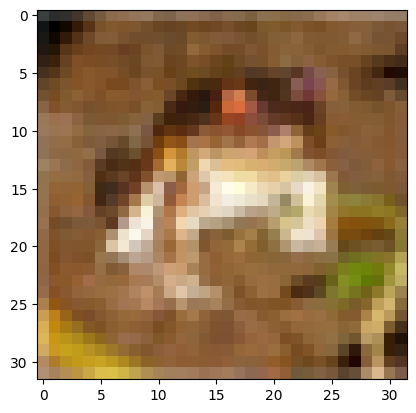

In [3]:
train_data = datasets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor()) #
test_data = datasets.CIFAR10('./data', train=False, download=True, transform=transforms.ToTensor()) #

imgs = torch.stack([img_t for img_t, _ in train_data], dim=3)
print(imgs.shape)
print(imgs.view(3, -1).mean(dim=1))
print(imgs.view(3, -1).std(dim=1))

img, label =train_data[0]

label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print(label_names[label])

plt.imshow(img.permute(1, 2, 0))
plt.show()

In [4]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      # transforms.Resize((28, 28)),
                                      # transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
                                       ])


# Dataset and Creating Train/Test Split

In [5]:
train_data = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test_data = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([128, 3, 32, 32])
torch.Size([128])


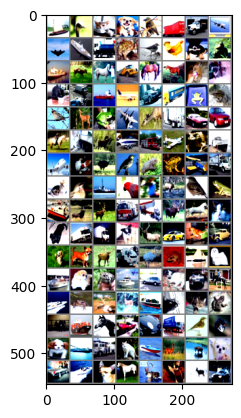

In [7]:
batch_size = 128
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


# Model Params for Group Normalization


In [9]:
from model import GN_Net

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

model = GN_Net().to(device)
summary(model, input_size=(3, 32, 32))

ship  bird  cat   dog   bird  truck truck plane plane ship  truck frog  bird  bird  dog   frog  ship  deer  horse truck horse horse dog   cat   cat   truck ship  plane car   truck frog  frog  bird  deer  frog  plane deer  truck car   car   horse cat   deer  ship  truck plane frog  ship  plane cat   bird  bird  frog  frog  plane truck cat   bird  ship  bird  bird  deer  bird  frog  ship  deer  deer  truck truck deer  horse cat   dog   truck truck dog   deer  car   dog   car   dog   dog   deer  truck bird  frog  ship  dog   ship  dog   frog  ship  car   dog   car   horse ship  frog  deer  deer  ship  cat   cat   frog  horse ship  horse car   car   truck bird  bird  dog   ship  truck cat   ship  deer  deer  dog   car   ship  dog   horse deer  cat   deer  car  
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 30, 30]             432
         GroupNorm-2           [-1, 16,

# Training and Testing for Group Normalization

In [10]:
train_losses_t = []
test_losses_t = []
train_acc_t = []
test_acc_t = []

model =  GN_Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_losses, train_acc = train(model, device, train_loader, optimizer, epoch)
    train_losses_t += train_losses
    train_acc_t.append(train_acc)
    test_losses, test_acc = test(model, device, test_loader)
    test_losses_t += test_losses
    test_acc_t.append(test_acc)

EPOCH: 0


Loss=1.6494905948638916 Batch_id=390 Accuracy=26.62: 100%|██████████| 391/391 [00:19<00:00, 20.41it/s]



Test set: Average loss: 1.6364, Accuracy: 3834/10000 (38.34%)

EPOCH: 1


Loss=1.4115365743637085 Batch_id=390 Accuracy=41.54: 100%|██████████| 391/391 [00:19<00:00, 19.67it/s]



Test set: Average loss: 1.4159, Accuracy: 4728/10000 (47.28%)

EPOCH: 2


Loss=1.4436413049697876 Batch_id=390 Accuracy=48.14: 100%|██████████| 391/391 [00:19<00:00, 20.45it/s]



Test set: Average loss: 1.3024, Accuracy: 5205/10000 (52.05%)

EPOCH: 3


Loss=1.2267346382141113 Batch_id=390 Accuracy=52.29: 100%|██████████| 391/391 [00:18<00:00, 20.63it/s]



Test set: Average loss: 1.2297, Accuracy: 5549/10000 (55.49%)

EPOCH: 4


Loss=1.3358466625213623 Batch_id=390 Accuracy=55.70: 100%|██████████| 391/391 [00:21<00:00, 18.24it/s]



Test set: Average loss: 1.1375, Accuracy: 5882/10000 (58.82%)

EPOCH: 5


Loss=1.1791350841522217 Batch_id=390 Accuracy=58.07: 100%|██████████| 391/391 [00:18<00:00, 20.77it/s]



Test set: Average loss: 1.1531, Accuracy: 5819/10000 (58.19%)

EPOCH: 6


Loss=1.140152931213379 Batch_id=390 Accuracy=59.60: 100%|██████████| 391/391 [00:19<00:00, 19.68it/s]



Test set: Average loss: 1.1051, Accuracy: 6019/10000 (60.19%)

EPOCH: 7


Loss=1.0642356872558594 Batch_id=390 Accuracy=61.22: 100%|██████████| 391/391 [00:19<00:00, 20.39it/s]



Test set: Average loss: 1.0505, Accuracy: 6250/10000 (62.50%)

EPOCH: 8


Loss=0.9674910306930542 Batch_id=390 Accuracy=62.52: 100%|██████████| 391/391 [00:18<00:00, 20.62it/s]



Test set: Average loss: 1.0177, Accuracy: 6381/10000 (63.81%)

EPOCH: 9


Loss=0.8177944421768188 Batch_id=390 Accuracy=63.53: 100%|██████████| 391/391 [00:20<00:00, 19.31it/s]



Test set: Average loss: 0.9707, Accuracy: 6535/10000 (65.35%)

EPOCH: 10


Loss=1.045640230178833 Batch_id=390 Accuracy=64.47: 100%|██████████| 391/391 [00:18<00:00, 20.71it/s]



Test set: Average loss: 0.9747, Accuracy: 6560/10000 (65.60%)

EPOCH: 11


Loss=1.162834882736206 Batch_id=390 Accuracy=64.91: 100%|██████████| 391/391 [00:19<00:00, 20.44it/s]



Test set: Average loss: 0.9918, Accuracy: 6523/10000 (65.23%)

EPOCH: 12


Loss=0.9067978858947754 Batch_id=390 Accuracy=66.04: 100%|██████████| 391/391 [00:20<00:00, 19.44it/s]



Test set: Average loss: 0.9132, Accuracy: 6750/10000 (67.50%)

EPOCH: 13


Loss=1.156581163406372 Batch_id=390 Accuracy=66.75: 100%|██████████| 391/391 [00:18<00:00, 20.90it/s]



Test set: Average loss: 0.9209, Accuracy: 6728/10000 (67.28%)

EPOCH: 14


Loss=0.8085015416145325 Batch_id=390 Accuracy=67.49: 100%|██████████| 391/391 [00:19<00:00, 20.52it/s]



Test set: Average loss: 0.8891, Accuracy: 6913/10000 (69.13%)

EPOCH: 15


Loss=0.938836395740509 Batch_id=390 Accuracy=68.06: 100%|██████████| 391/391 [00:20<00:00, 19.24it/s]



Test set: Average loss: 0.8974, Accuracy: 6904/10000 (69.04%)

EPOCH: 16


Loss=0.885057806968689 Batch_id=390 Accuracy=68.84: 100%|██████████| 391/391 [00:18<00:00, 20.96it/s]



Test set: Average loss: 0.8459, Accuracy: 7087/10000 (70.87%)

EPOCH: 17


Loss=0.9510628581047058 Batch_id=390 Accuracy=69.23: 100%|██████████| 391/391 [00:19<00:00, 19.73it/s]



Test set: Average loss: 0.8334, Accuracy: 7068/10000 (70.68%)

EPOCH: 18


Loss=0.6325114965438843 Batch_id=390 Accuracy=69.52: 100%|██████████| 391/391 [00:18<00:00, 21.12it/s]



Test set: Average loss: 0.9042, Accuracy: 6897/10000 (68.97%)

EPOCH: 19


Loss=0.8175309300422668 Batch_id=390 Accuracy=69.56: 100%|██████████| 391/391 [00:18<00:00, 20.81it/s]



Test set: Average loss: 0.8425, Accuracy: 7042/10000 (70.42%)



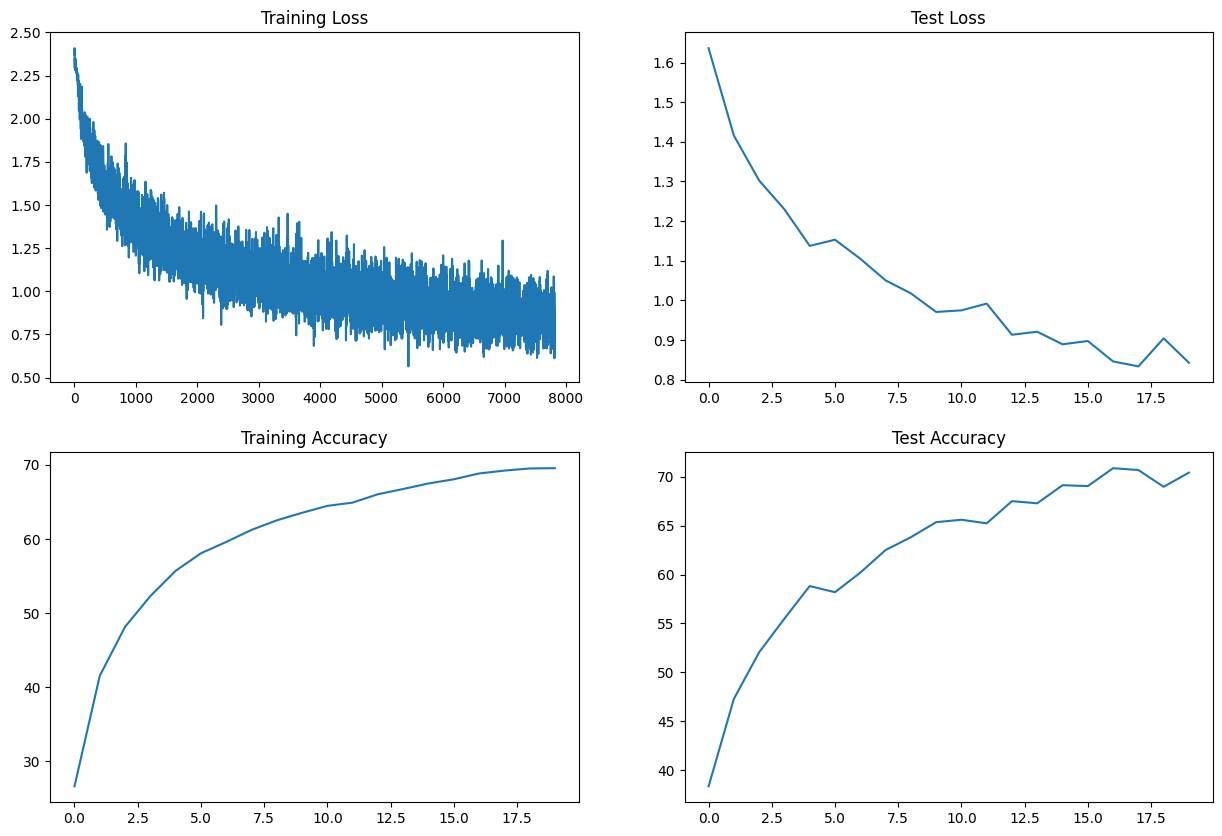

In [11]:
plot_loss_acc(train_losses_t, train_acc_t, test_losses_t, test_acc_t)

# Model Params for Layer Normalization

In [12]:
from model import LN_Net

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

model = LN_Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 30, 30]             108
         LayerNorm-2            [-1, 4, 30, 30]           7,200
           Dropout-3            [-1, 4, 30, 30]               0
              ReLU-4            [-1, 4, 30, 30]               0
            Conv2d-5            [-1, 4, 28, 28]             144
         LayerNorm-6            [-1, 4, 28, 28]           6,272
           Dropout-7            [-1, 4, 28, 28]               0
              ReLU-8            [-1, 4, 28, 28]               0
            Conv2d-9            [-1, 4, 28, 28]              16
             ReLU-10            [-1, 4, 28, 28]               0
        MaxPool2d-11            [-1, 4, 14, 14]               0
           Conv2d-12            [-1, 8, 14, 14]             288
        LayerNorm-13            [-1, 8, 14, 14]           3,136
          Dropout-14            [-1, 8,

# Training and Testing for Layer Normalization

In [13]:
train_losses_t = []
test_losses_t = []
train_acc_t = []
test_acc_t = []

model =  LN_Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_losses, train_acc = train(model, device, train_loader, optimizer, epoch)
    train_losses_t += train_losses
    train_acc_t.append(train_acc)
    test_losses, test_acc = test(model, device, test_loader)
    test_losses_t += test_losses
    test_acc_t.append(test_acc)

EPOCH: 0


Loss=1.7913696765899658 Batch_id=390 Accuracy=24.26: 100%|██████████| 391/391 [00:19<00:00, 19.76it/s]



Test set: Average loss: 1.8359, Accuracy: 3047/10000 (30.47%)

EPOCH: 1


Loss=1.8140068054199219 Batch_id=390 Accuracy=32.85: 100%|██████████| 391/391 [00:23<00:00, 16.33it/s]



Test set: Average loss: 1.7659, Accuracy: 3514/10000 (35.14%)

EPOCH: 2


Loss=1.7036031484603882 Batch_id=390 Accuracy=36.00: 100%|██████████| 391/391 [00:26<00:00, 14.97it/s]



Test set: Average loss: 1.6538, Accuracy: 3832/10000 (38.32%)

EPOCH: 3


Loss=1.675955057144165 Batch_id=390 Accuracy=38.94: 100%|██████████| 391/391 [00:21<00:00, 18.03it/s]



Test set: Average loss: 1.5703, Accuracy: 4221/10000 (42.21%)

EPOCH: 4


Loss=1.560224175453186 Batch_id=390 Accuracy=41.33: 100%|██████████| 391/391 [00:18<00:00, 21.08it/s]



Test set: Average loss: 1.5444, Accuracy: 4376/10000 (43.76%)

EPOCH: 5


Loss=1.539516568183899 Batch_id=390 Accuracy=42.91: 100%|██████████| 391/391 [00:18<00:00, 21.17it/s]



Test set: Average loss: 1.4874, Accuracy: 4561/10000 (45.61%)

EPOCH: 6


Loss=1.4462230205535889 Batch_id=390 Accuracy=44.33: 100%|██████████| 391/391 [00:22<00:00, 17.48it/s]



Test set: Average loss: 1.4267, Accuracy: 4816/10000 (48.16%)

EPOCH: 7


Loss=1.412501573562622 Batch_id=390 Accuracy=45.64: 100%|██████████| 391/391 [00:18<00:00, 21.12it/s]



Test set: Average loss: 1.3857, Accuracy: 5009/10000 (50.09%)

EPOCH: 8


Loss=1.616355538368225 Batch_id=390 Accuracy=46.84: 100%|██████████| 391/391 [00:18<00:00, 21.19it/s]



Test set: Average loss: 1.3594, Accuracy: 5084/10000 (50.84%)

EPOCH: 9


Loss=1.3724298477172852 Batch_id=390 Accuracy=47.67: 100%|██████████| 391/391 [00:20<00:00, 19.49it/s]



Test set: Average loss: 1.3347, Accuracy: 5156/10000 (51.56%)

EPOCH: 10


Loss=1.2325087785720825 Batch_id=390 Accuracy=48.99: 100%|██████████| 391/391 [00:18<00:00, 21.34it/s]



Test set: Average loss: 1.3381, Accuracy: 5115/10000 (51.15%)

EPOCH: 11


Loss=1.163735032081604 Batch_id=390 Accuracy=49.92: 100%|██████████| 391/391 [00:19<00:00, 19.90it/s]



Test set: Average loss: 1.3184, Accuracy: 5306/10000 (53.06%)

EPOCH: 12


Loss=1.365911602973938 Batch_id=390 Accuracy=50.57: 100%|██████████| 391/391 [00:19<00:00, 19.58it/s]



Test set: Average loss: 1.3017, Accuracy: 5316/10000 (53.16%)

EPOCH: 13


Loss=1.3280149698257446 Batch_id=390 Accuracy=51.36: 100%|██████████| 391/391 [00:19<00:00, 20.45it/s]



Test set: Average loss: 1.2660, Accuracy: 5415/10000 (54.15%)

EPOCH: 14


Loss=1.0661952495574951 Batch_id=390 Accuracy=52.16: 100%|██████████| 391/391 [00:19<00:00, 20.49it/s]



Test set: Average loss: 1.2539, Accuracy: 5498/10000 (54.98%)

EPOCH: 15


Loss=1.2607088088989258 Batch_id=390 Accuracy=52.96: 100%|██████████| 391/391 [00:19<00:00, 19.84it/s]



Test set: Average loss: 1.2796, Accuracy: 5400/10000 (54.00%)

EPOCH: 16


Loss=1.2618833780288696 Batch_id=390 Accuracy=53.49: 100%|██████████| 391/391 [00:19<00:00, 19.76it/s]



Test set: Average loss: 1.2275, Accuracy: 5527/10000 (55.27%)

EPOCH: 17


Loss=1.3760967254638672 Batch_id=390 Accuracy=53.93: 100%|██████████| 391/391 [00:19<00:00, 20.53it/s]



Test set: Average loss: 1.2297, Accuracy: 5559/10000 (55.59%)

EPOCH: 18


Loss=1.3206932544708252 Batch_id=390 Accuracy=54.82: 100%|██████████| 391/391 [00:20<00:00, 18.73it/s]



Test set: Average loss: 1.1849, Accuracy: 5765/10000 (57.65%)

EPOCH: 19


Loss=1.157336711883545 Batch_id=390 Accuracy=55.49: 100%|██████████| 391/391 [00:20<00:00, 19.12it/s]



Test set: Average loss: 1.1603, Accuracy: 5868/10000 (58.68%)



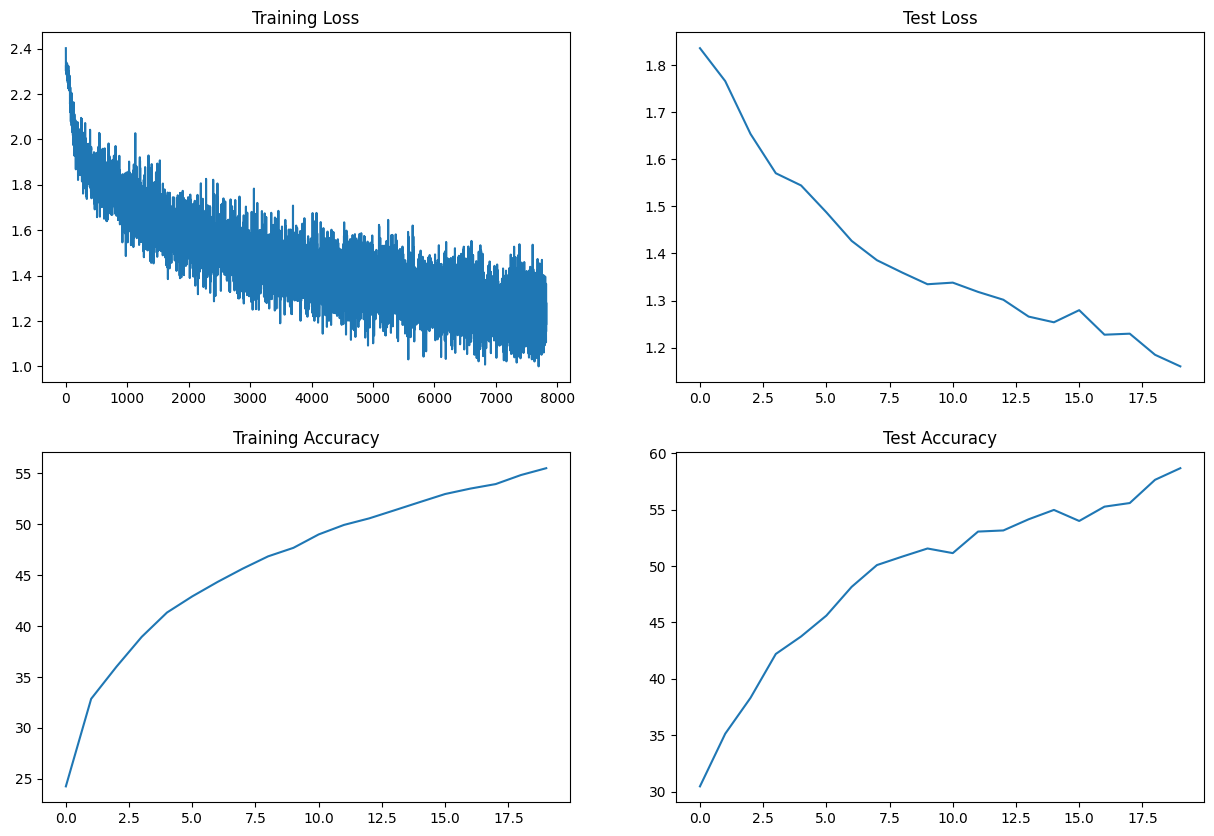

In [14]:
plot_loss_acc(train_losses_t, train_acc_t, test_losses_t, test_acc_t)

# Model Params for Batch Normalization

In [15]:
from model import BN_Net

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

model = BN_Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
           Dropout-3           [-1, 16, 32, 32]               0
              ReLU-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,608
       BatchNorm2d-6           [-1, 32, 32, 32]              64
           Dropout-7           [-1, 32, 32, 32]               0
              ReLU-8           [-1, 32, 32, 32]               0
            Conv2d-9            [-1, 8, 34, 34]             256
             ReLU-10            [-1, 8, 34, 34]               0
        MaxPool2d-11            [-1, 8, 17, 17]               0
           Conv2d-12           [-1, 16, 15, 15]           1,152
      BatchNorm2d-13           [-1, 16, 15, 15]              32
          Dropout-14           [-1, 16,

# Training and Testing Batch Normalisation


In [16]:
train_losses_t = []
test_losses_t = []
train_acc_t = []
test_acc_t = []

model =  BN_Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_losses, train_acc = train(model, device, train_loader, optimizer, epoch)
    train_losses_t += train_losses
    train_acc_t.append(train_acc)
    test_losses, test_acc = test(model, device, test_loader)
    test_losses_t += test_losses
    test_acc_t.append(test_acc)

EPOCH: 0


Loss=1.5064600706100464 Batch_id=390 Accuracy=35.95: 100%|██████████| 391/391 [00:21<00:00, 18.43it/s]



Test set: Average loss: 1.5107, Accuracy: 4410/10000 (44.10%)

EPOCH: 1


Loss=1.1112895011901855 Batch_id=390 Accuracy=52.69: 100%|██████████| 391/391 [00:19<00:00, 19.56it/s]



Test set: Average loss: 1.2468, Accuracy: 5581/10000 (55.81%)

EPOCH: 2


Loss=0.9680533409118652 Batch_id=390 Accuracy=59.08: 100%|██████████| 391/391 [00:19<00:00, 19.67it/s]



Test set: Average loss: 1.1126, Accuracy: 5983/10000 (59.83%)

EPOCH: 3


Loss=0.8982959985733032 Batch_id=390 Accuracy=62.50: 100%|██████████| 391/391 [00:21<00:00, 18.38it/s]



Test set: Average loss: 1.0257, Accuracy: 6316/10000 (63.16%)

EPOCH: 4


Loss=0.7442597150802612 Batch_id=390 Accuracy=65.32: 100%|██████████| 391/391 [00:21<00:00, 18.26it/s]



Test set: Average loss: 0.9691, Accuracy: 6593/10000 (65.93%)

EPOCH: 5


Loss=1.1182361841201782 Batch_id=390 Accuracy=67.18: 100%|██████████| 391/391 [00:20<00:00, 18.78it/s]



Test set: Average loss: 0.9329, Accuracy: 6720/10000 (67.20%)

EPOCH: 6


Loss=0.7886048555374146 Batch_id=390 Accuracy=68.71: 100%|██████████| 391/391 [00:19<00:00, 19.83it/s]



Test set: Average loss: 0.8834, Accuracy: 6879/10000 (68.79%)

EPOCH: 7


Loss=0.9625855684280396 Batch_id=390 Accuracy=69.58: 100%|██████████| 391/391 [00:19<00:00, 19.65it/s]



Test set: Average loss: 0.8659, Accuracy: 6951/10000 (69.51%)

EPOCH: 8


Loss=0.9365614056587219 Batch_id=390 Accuracy=70.45: 100%|██████████| 391/391 [00:20<00:00, 18.77it/s]



Test set: Average loss: 0.9367, Accuracy: 6729/10000 (67.29%)

EPOCH: 9


Loss=0.7783432602882385 Batch_id=390 Accuracy=71.29: 100%|██████████| 391/391 [00:20<00:00, 18.98it/s]



Test set: Average loss: 0.7928, Accuracy: 7216/10000 (72.16%)

EPOCH: 10


Loss=0.7496722936630249 Batch_id=390 Accuracy=71.95: 100%|██████████| 391/391 [00:19<00:00, 20.29it/s]



Test set: Average loss: 0.7934, Accuracy: 7269/10000 (72.69%)

EPOCH: 11


Loss=0.8547946810722351 Batch_id=390 Accuracy=72.38: 100%|██████████| 391/391 [00:19<00:00, 20.11it/s]



Test set: Average loss: 0.8111, Accuracy: 7142/10000 (71.42%)

EPOCH: 12


Loss=0.5922278165817261 Batch_id=390 Accuracy=72.64: 100%|██████████| 391/391 [00:20<00:00, 18.93it/s]



Test set: Average loss: 0.7768, Accuracy: 7230/10000 (72.30%)

EPOCH: 13


Loss=0.8676217794418335 Batch_id=390 Accuracy=73.43: 100%|██████████| 391/391 [00:20<00:00, 19.32it/s]



Test set: Average loss: 0.7615, Accuracy: 7392/10000 (73.92%)

EPOCH: 14


Loss=0.7282246351242065 Batch_id=390 Accuracy=73.64: 100%|██████████| 391/391 [00:19<00:00, 20.07it/s]



Test set: Average loss: 0.8131, Accuracy: 7276/10000 (72.76%)

EPOCH: 15


Loss=0.6710546612739563 Batch_id=390 Accuracy=74.05: 100%|██████████| 391/391 [00:19<00:00, 20.21it/s]



Test set: Average loss: 0.7975, Accuracy: 7204/10000 (72.04%)

EPOCH: 16


Loss=0.7954014539718628 Batch_id=390 Accuracy=74.50: 100%|██████████| 391/391 [00:20<00:00, 19.17it/s]



Test set: Average loss: 0.7549, Accuracy: 7399/10000 (73.99%)

EPOCH: 17


Loss=0.6918328404426575 Batch_id=390 Accuracy=74.76: 100%|██████████| 391/391 [00:20<00:00, 19.47it/s]



Test set: Average loss: 0.7670, Accuracy: 7344/10000 (73.44%)

EPOCH: 18


Loss=0.8179177045822144 Batch_id=390 Accuracy=74.88: 100%|██████████| 391/391 [00:19<00:00, 20.07it/s]



Test set: Average loss: 0.7390, Accuracy: 7410/10000 (74.10%)

EPOCH: 19


Loss=0.6008279323577881 Batch_id=390 Accuracy=75.28: 100%|██████████| 391/391 [00:19<00:00, 20.11it/s]



Test set: Average loss: 0.7769, Accuracy: 7273/10000 (72.73%)



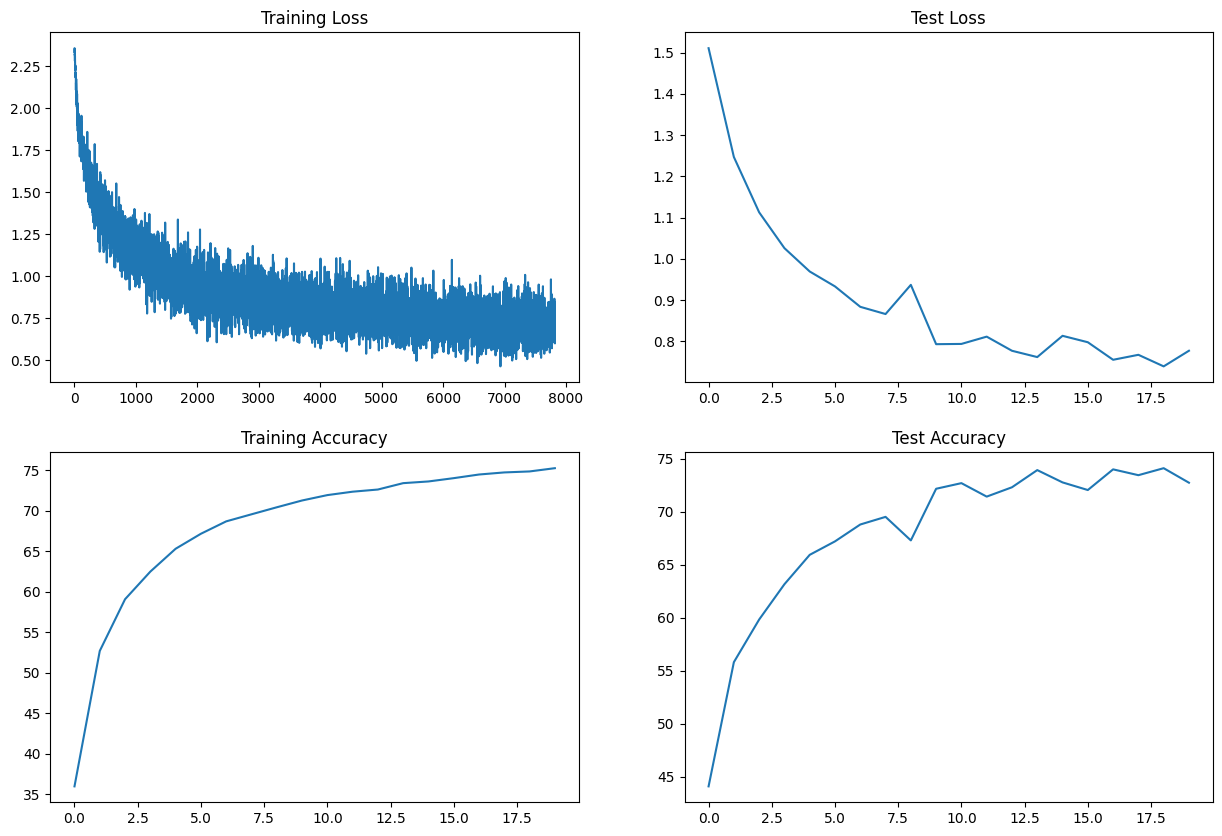

In [17]:
plot_loss_acc(train_losses_t, train_acc_t, test_losses_t, test_acc_t)